In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_excel("../Dataset/entrenamiento.xlsx")
data = data.rename(columns={"C7.1": "C8", "des": "QUALITY"})
features = data.drop(columns=["QUALITY"])
target = data["QUALITY"]

In [3]:
data.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,QUALITY
0,6.8,0.190620,0.307485,18.1,46.00,32.0,4.897840,1.00000,3.27,0.392042,8.8,5
1,6.2,0.246860,NaN,5.0,43.00,50.0,5.241747,0.99318,3.23,0.494696,10.8,6
2,6.7,0.350657,0.329304,12.1,0.04,61.0,5.517453,0.99794,3.31,0.457425,9.7,5
3,6.8,0.254642,0.405465,13.3,53.00,48.0,5.273000,0.99740,3.09,0.371564,9.4,5
4,6.6,0.215111,0.239017,15.8,35.00,46.0,5.241747,0.99820,3.24,0.412110,9.2,5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3918 entries, 0 to 3917
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   C1       3684 non-null   float64
 1   C2       3664 non-null   float64
 2   C3       3648 non-null   float64
 3   C4       3636 non-null   float64
 4   C5       3659 non-null   float64
 5   C6       3655 non-null   float64
 6   C7       3645 non-null   float64
 7   C8       3646 non-null   float64
 8   C9       3658 non-null   float64
 9   C10      3639 non-null   float64
 10  C11      3658 non-null   float64
 11  QUALITY  3918 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 367.4 KB


In [5]:
# Calculate the number of nan in the dataset
data.isna().sum()

C1         234
C2         254
C3         270
C4         282
C5         259
C6         263
C7         273
C8         272
C9         260
C10        279
C11        260
QUALITY      0
dtype: int64

In [6]:
# Getting a count of how many rows have 0 NA, 1 NA, 2 NA, 3 NA, 4 NA, 5 NA
data.isna().sum(axis=1).value_counts()

0    1788
1    1502
2     496
3     117
4      14
5       1
dtype: int64

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
C1,3684.0,6.857166,0.846430,3.800000,6.300000,6.800000,7.300000,14.200000
C2,3664.0,0.421440,0.988207,0.076961,0.190620,0.231112,0.285179,6.913737
C3,3648.0,0.284054,0.086887,0.000000,0.239017,0.277632,0.329304,0.802002
C4,3636.0,6.424642,5.084063,0.600000,1.700000,5.300000,9.900000,65.800000
C5,3659.0,40.685294,25.106022,0.020000,33.000000,41.000000,49.000000,346.000000
C6,3655.0,35.216142,17.167346,2.000000,23.000000,34.000000,46.000000,289.000000
C7,3645.0,4.885591,0.341723,2.302585,4.691348,4.912655,5.129899,6.089045
C8,3646.0,65.824651,245.359289,0.987110,0.991800,0.994100,0.996825,1001.000000
C9,3658.0,3.188291,0.152155,2.720000,3.090000,3.180000,3.280000,3.820000
C10,3639.0,0.395421,0.074535,0.198851,0.343590,0.385262,0.438255,0.732368


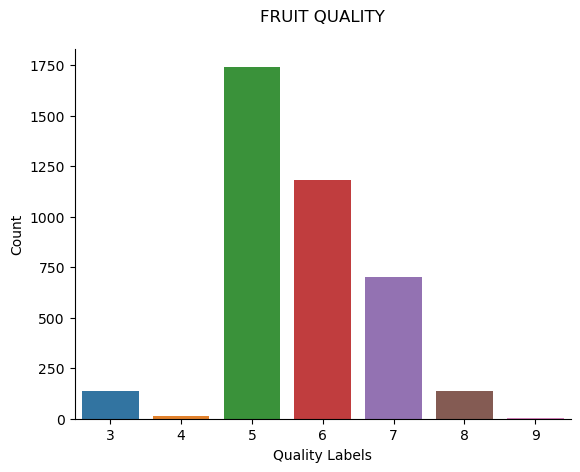

In [8]:
sns.barplot(x=data.QUALITY.unique(), y=data.QUALITY.value_counts(""))
plt.grid(False)
sns.despine()
plt.title("FRUIT QUALITY", pad=20)
plt.xlabel("Quality Labels")
plt.ylabel("Count")
plt.show()

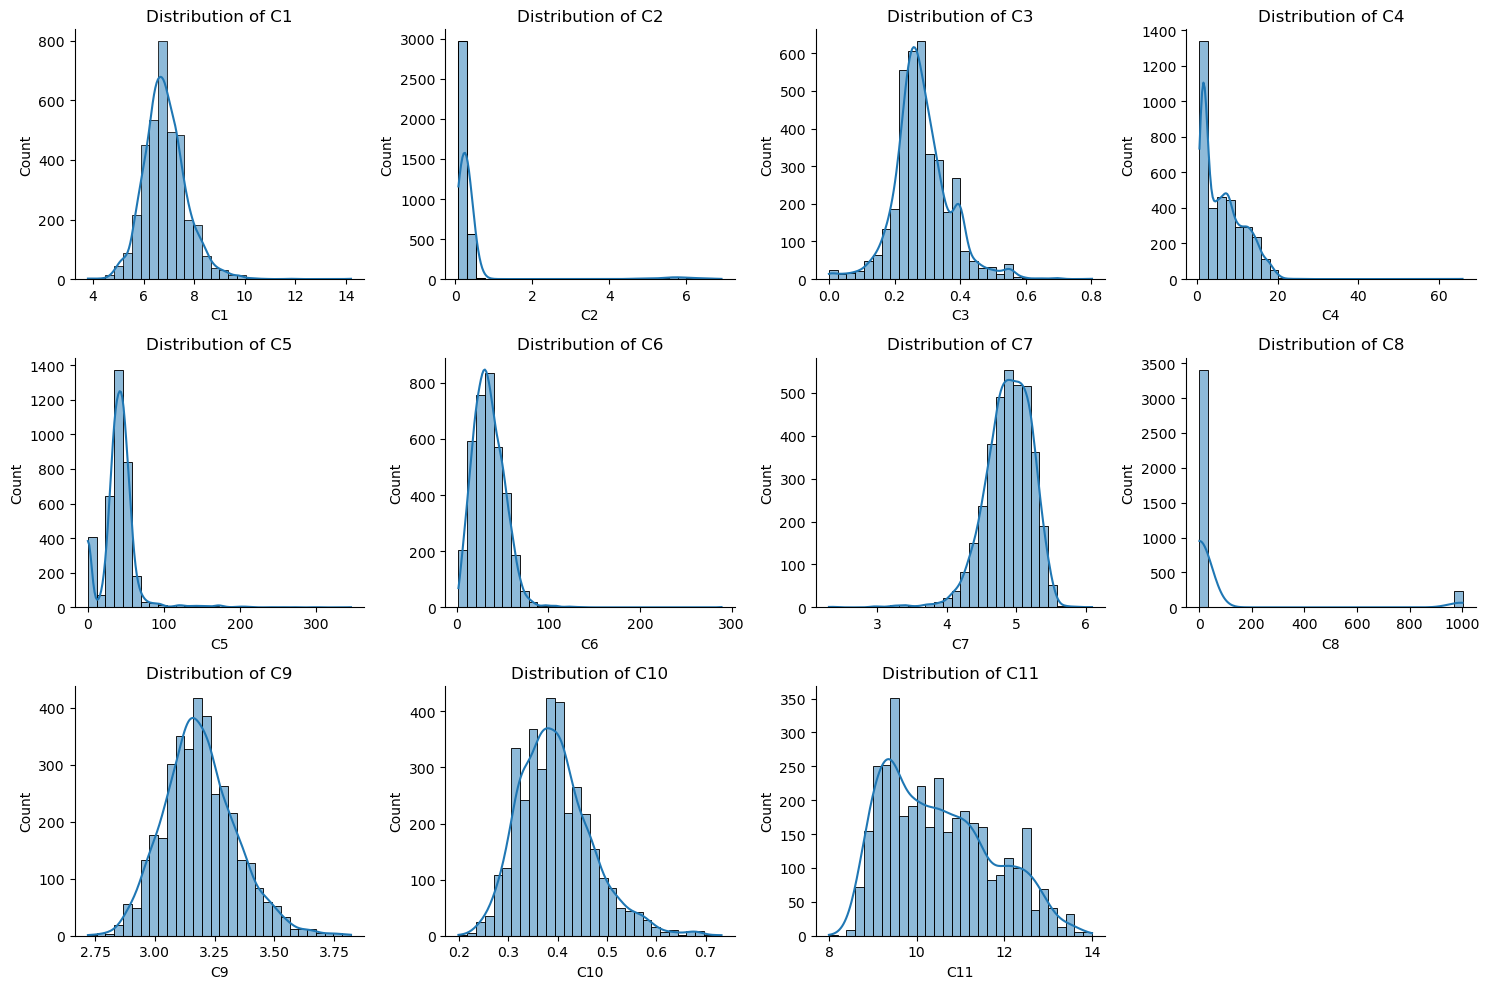

In [9]:
# Visualize the distribution of the data for each feature
plt.figure(figsize=(15, 10))

# Plotting the distribution of each column
for i, column in enumerate(features.columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(features[column], bins=30, kde=True)
    plt.title(f"Distribution of {column}")
    plt.tight_layout()
    plt.grid(False)
    sns.despine()

plt.show()

- Most features seem to be somewhat normally distributed, while some have a slightly skewed distribution.
- There are some features with noticeable peaks, suggesting potential groups or clusters in the data.
- Some features have a wider range than others, which can affect distance-based algorithms like KNN.

In [10]:
# Correlation Dataframe
corr = data.corr()  # -1 => Strong relationship (negative slope) +1 => Strong relationship (positive slope)
corr

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,QUALITY
C1,1.000000,-0.113640,0.298696,0.084040,0.004681,-0.051602,0.072919,0.078148,-0.423921,-0.010296,-0.121310,-0.129842
C2,-0.113640,1.000000,-0.109347,-0.010240,-0.001061,-0.044333,-0.045809,0.006703,0.068230,-0.014906,-0.020868,-0.055131
C3,0.298696,-0.109347,1.000000,0.098756,0.083248,0.092613,0.116557,0.008373,-0.153193,0.071230,-0.055949,0.023811
C4,0.084040,-0.010240,0.098756,1.000000,0.064154,0.299380,0.376979,-0.026913,-0.190618,-0.006357,-0.456232,-0.098282
C5,0.004681,-0.001061,0.083248,0.064154,1.000000,0.089958,0.154300,-0.032985,-0.057077,0.027657,-0.279430,-0.140491
C6,-0.051602,-0.044333,0.092613,0.299380,0.089958,1.000000,0.604173,-0.033861,0.019990,0.067075,-0.263707,0.006906
C7,0.072919,-0.045809,0.116557,0.376979,0.154300,0.604173,1.000000,-0.001804,0.023008,0.132883,-0.423872,-0.115745
C8,0.078148,0.006703,0.008373,-0.026913,-0.032985,-0.033861,-0.001804,1.000000,0.022892,-0.004982,-0.027391,0.013291
C9,-0.423921,0.068230,-0.153193,-0.190618,-0.057077,0.019990,0.023008,0.022892,1.000000,0.168501,0.126298,0.110884
C10,-0.010296,-0.014906,0.071230,-0.006357,0.027657,0.067075,0.132883,-0.004982,0.168501,1.000000,-0.050914,0.039017


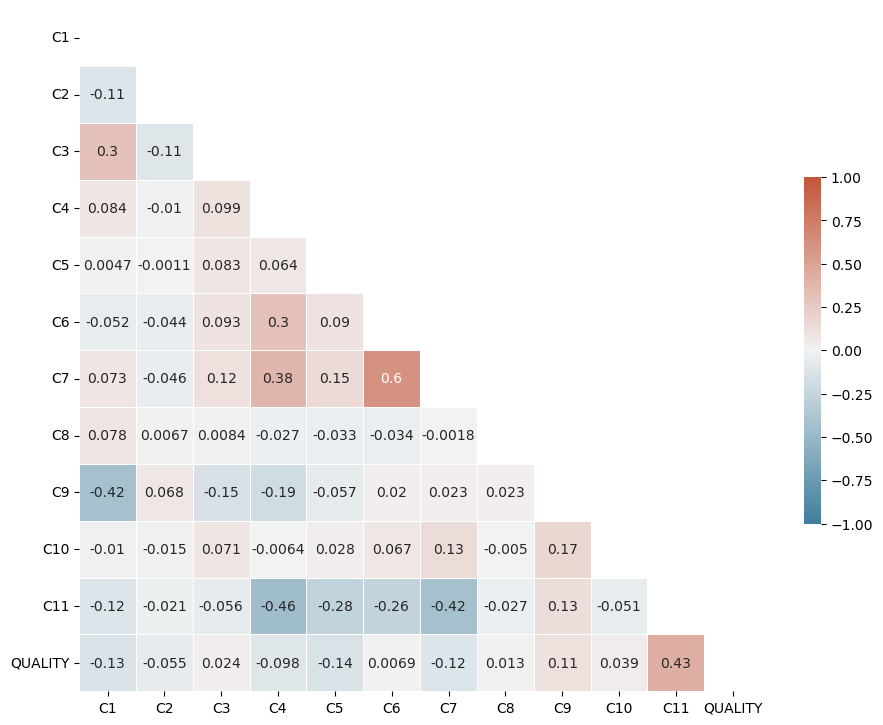

In [11]:
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# Rotate y-axis labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.grid(False)

plt.show()

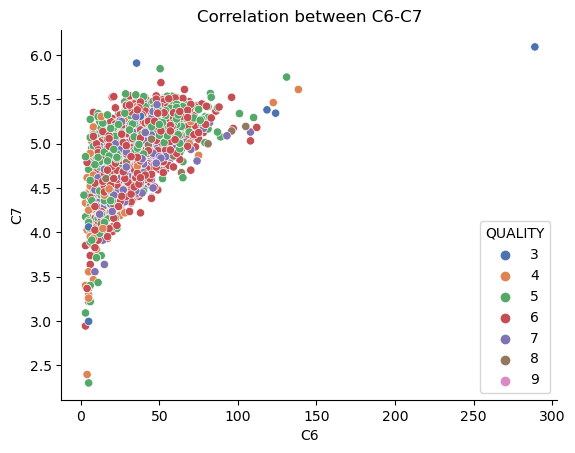

In [12]:
sns.scatterplot(x=data["C6"], y=data["C7"], hue=data["QUALITY"], palette="deep")
plt.grid(False)
plt.title("Correlation between C6-C7")
sns.despine()

In [13]:
nan_values = data.isna()

# 'sum()' method on the boolean DataFrame to count the number of True values in each column
nan_count_per_row = nan_values.sum(axis=1)

# Count the number of rows with non-zero sum
total_rows_with_nan = (nan_count_per_row > 0).sum()

print(f"Total rows with NaN values:{total_rows_with_nan}")

Total rows with NaN values:2130


In [14]:
# Dataframe which contains only rows with nan values
data_nan_rows = features[features.isna().any(axis=1)]
data_nan_rows

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11
1,6.2,0.246860,NaN,5.00,43.00,50.0,5.241747,0.99318,3.23,0.494696,10.8
6,9.2,0.536493,0.207014,6.20,42.00,15.0,4.543295,0.99480,NaN,0.292670,10.1
7,6.4,4.836282,0.254642,5.85,42.00,24.0,4.605170,992.00000,3.23,0.277632,NaN
10,6.9,0.182322,0.307485,1.50,31.00,38.0,4.997212,0.99310,NaN,0.444686,11.0
13,4.4,0.378436,0.095310,2.80,NaN,31.0,4.718499,0.98816,3.48,0.292670,13.1
...,...,...,...,...,...,...,...,...,...,...,...
3908,8.0,0.246860,0.350657,7.10,45.00,41.0,5.135798,0.99590,3.17,NaN,10.6
3911,6.1,NaN,0.148420,1.30,0.06,36.0,4.844187,0.99353,3.13,0.378436,8.7
3912,6.6,0.223144,0.270027,NaN,35.00,32.0,4.852030,0.99210,3.41,0.385262,11.3
3913,7.7,NaN,0.215111,11.20,31.00,41.0,5.123964,0.99480,3.12,0.357674,11.3


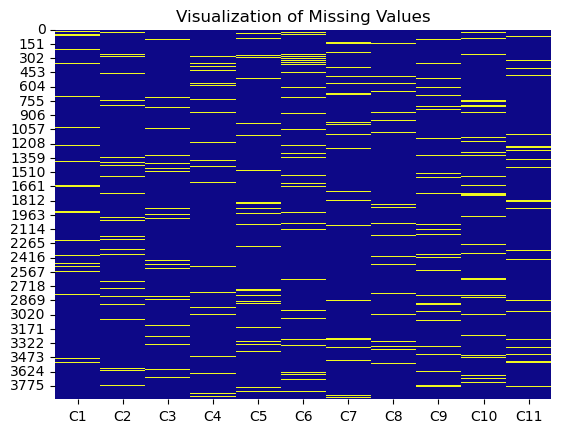

In [15]:
# Visualize how nan values are distributed across the dataset
sns.heatmap(features.isna(), cbar=False, cmap="plasma")
plt.title("Visualization of Missing Values")
plt.show()

In [16]:
# Initialize the KNN Imputer with default k=5
knn_imputer = KNNImputer()
imputed_features = knn_imputer.fit_transform(features)

# Convert the imputed features back to a dataframe
imputed_df = pd.DataFrame(imputed_features, columns=features.columns)
# Add the target column back
imputed_df['QUALITY'] = target

imputed_df.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,QUALITY
0,6.8,0.190620,0.307485,18.1,46.00,32.0,4.897840,1.00000,3.27,0.392042,8.8,5
1,6.2,0.246860,0.225086,5.0,43.00,50.0,5.241747,0.99318,3.23,0.494696,10.8,6
2,6.7,0.350657,0.329304,12.1,0.04,61.0,5.517453,0.99794,3.31,0.457425,9.7,5
3,6.8,0.254642,0.405465,13.3,53.00,48.0,5.273000,0.99740,3.09,0.371564,9.4,5
4,6.6,0.215111,0.239017,15.8,35.00,46.0,5.241747,0.99820,3.24,0.412110,9.2,5


In [107]:
# Apply KNN imputation
knn_imputer = KNNImputer()
imputed_features = knn_imputer.fit_transform(features)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(imputed_features)

# Convert the imputed features back to a dataframe
imputed_df = pd.DataFrame(scaled_features, columns=features.columns)
# Add the target column back
imputed_df['QUALITY'] = target

imputed_df

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,QUALITY
0,-0.065234,-0.240536,0.280720,2.354711,0.223298,-0.194477,0.033960,-0.279028,0.549423,-0.045617,-1.422760,5
1,-0.790061,-0.182141,-0.696152,-0.281974,0.100501,0.875876,1.064083,-0.279057,0.280456,1.371026,0.249626,6
2,-0.186038,-0.074366,0.539395,1.147069,-1.657945,1.529980,1.889920,-0.279037,0.818390,0.856675,-0.670186,5
3,-0.065234,-0.174061,1.442321,1.388597,0.509823,0.756948,1.157696,-0.279039,-0.660929,-0.328224,-0.921044,5
4,-0.306843,-0.215106,-0.530996,1.891782,-0.226956,0.638019,1.064083,-0.279036,0.347697,0.231318,-1.088283,5
...,...,...,...,...,...,...,...,...,...,...,...,...
3913,1.022007,1.147154,-0.814406,0.965923,-0.390685,0.340699,0.711282,-0.279050,-0.459204,-0.519896,0.667723,7
3914,1.505225,-0.045522,-0.163356,-0.946177,0.468891,0.875876,0.983774,-0.279061,-1.064380,-0.616740,0.584104,5
3915,-0.910865,-0.284354,-0.345751,-0.080701,-1.658354,-0.372869,0.270275,-0.279050,3.306336,-0.233377,0.166007,6
3916,1.626029,-0.190285,0.539395,0.281592,0.337908,0.816412,1.365378,-0.279038,0.818390,0.231318,-0.837425,6


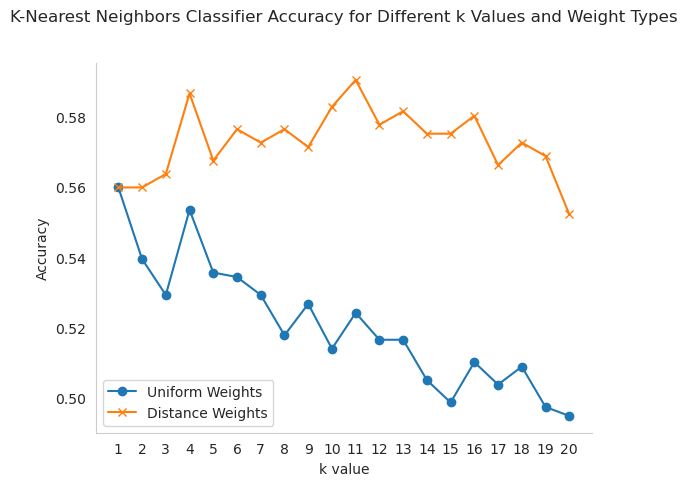

In [108]:
# Consolidated Code for K-Nearest Neighbors (KNN) Classification
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(imputed_df.drop(columns="QUALITY"), imputed_df['QUALITY'],
                                                    test_size=0.2,
                                                    random_state=42)

# Determine the optimal k value and weighting scheme for KNN
k_values = list(range(1, 21))
accuracies_uniform = []
accuracies_distance = []

for k in k_values:
    # Uniform weights
    knn_uniform = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn_uniform.fit(X_train, y_train)
    preds_uniform = knn_uniform.predict(X_test)
    accuracies_uniform.append(accuracy_score(y_test, preds_uniform))

    # Distance weights
    knn_distance = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn_distance.fit(X_train, y_train)
    preds_distance = knn_distance.predict(X_test)
    accuracies_distance.append(accuracy_score(y_test, preds_distance))

# VISUALIZATION 
plt.plot(k_values, accuracies_uniform, label='Uniform Weights', marker='o')
plt.plot(k_values, accuracies_distance, label='Distance Weights', marker='x')
plt.xlabel('k value')
plt.ylabel('Accuracy')

# Set the title with a pad to control the distance from the plot
plt.title('K-Nearest Neighbors Classifier Accuracy for Different k Values and Weight Types', pad=30)

plt.legend()
plt.grid(True)
plt.xticks(k_values)
plt.grid()

# Removing the right and top borders
ax = plt.gca()  # Get the current Axes instance
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['top'].set_visible(False)  # Hide the top spine

plt.show()
